## SCALib Test

Module AES128 not found, compiling instrumented Tiny-AES shared library


AES128.c:988:13: warning: ‘Cipher’ defined but not used [-Wunused-function]
  988 | static void Cipher(state_t* state, const uint8_t* RoundKey)
      |             ^~~~~~


Module AES192 not found, compiling instrumented Tiny-AES shared library


AES192.c:624:9: warning: ‘AES_KEYLEN’ redefined
  624 | #define AES_KEYLEN 16   // Key length in bytes
      |         ^~~~~~~~~~
<command-line>: note: this is the location of the previous definition
AES192.c:988:13: warning: ‘Cipher’ defined but not used [-Wunused-function]
  988 | static void Cipher(state_t* state, const uint8_t* RoundKey)
      |             ^~~~~~


Module AES256 not found, compiling instrumented Tiny-AES shared library


AES256.c:624:9: warning: ‘AES_KEYLEN’ redefined
  624 | #define AES_KEYLEN 16   // Key length in bytes
      |         ^~~~~~~~~~
<command-line>: note: this is the location of the previous definition
AES256.c:988:13: warning: ‘Cipher’ defined but not used [-Wunused-function]
  988 | static void Cipher(state_t* state, const uint8_t* RoundKey)
      |             ^~~~~~


Ignoring exception:
('No input specification for OracleAES: input_conditions must be declared in OracleAES.__new__', "'OracleAES' object has no attribute 'input_conditions'")
Ignoring exception:
('No input specification for OracleAES: input_conditions must be declared in OracleAES.__new__', "'OracleAES' object has no attribute 'input_conditions'")
Ignoring exception:
('No input specification for OracleAES: input_conditions must be declared in OracleAES.__new__', "'OracleAES' object has no attribute 'input_conditions'")
Ignoring exception:
('No input specification for OracleAES: input_conditions must be declared in OracleAES.__new__', "'OracleAES' object has no attribute 'input_conditions'")


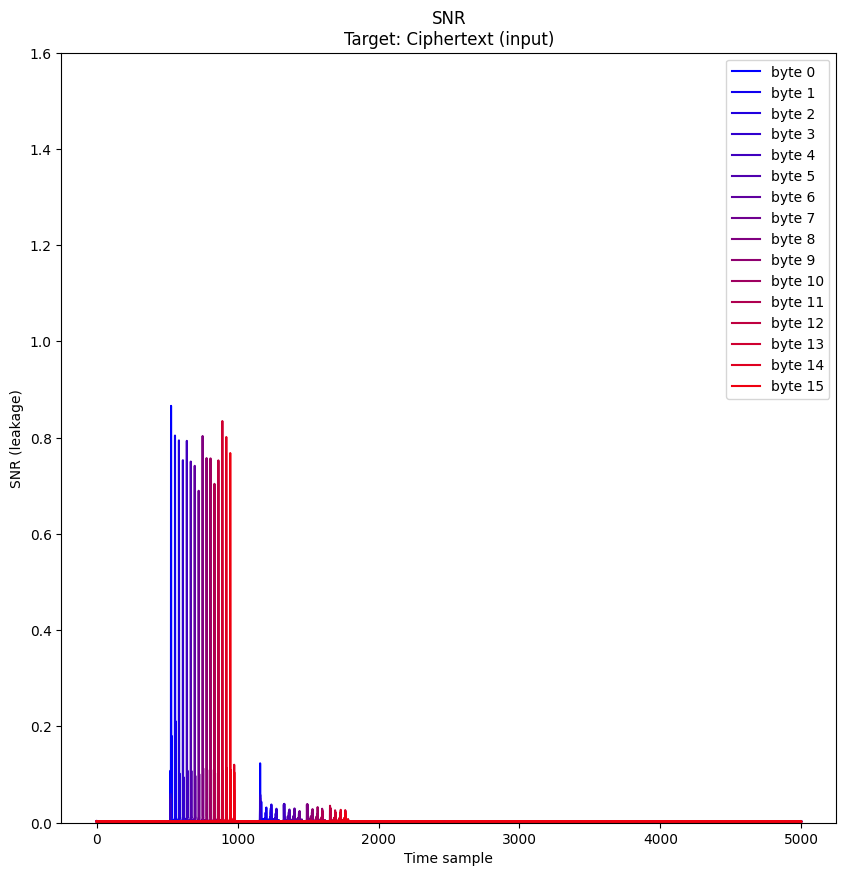

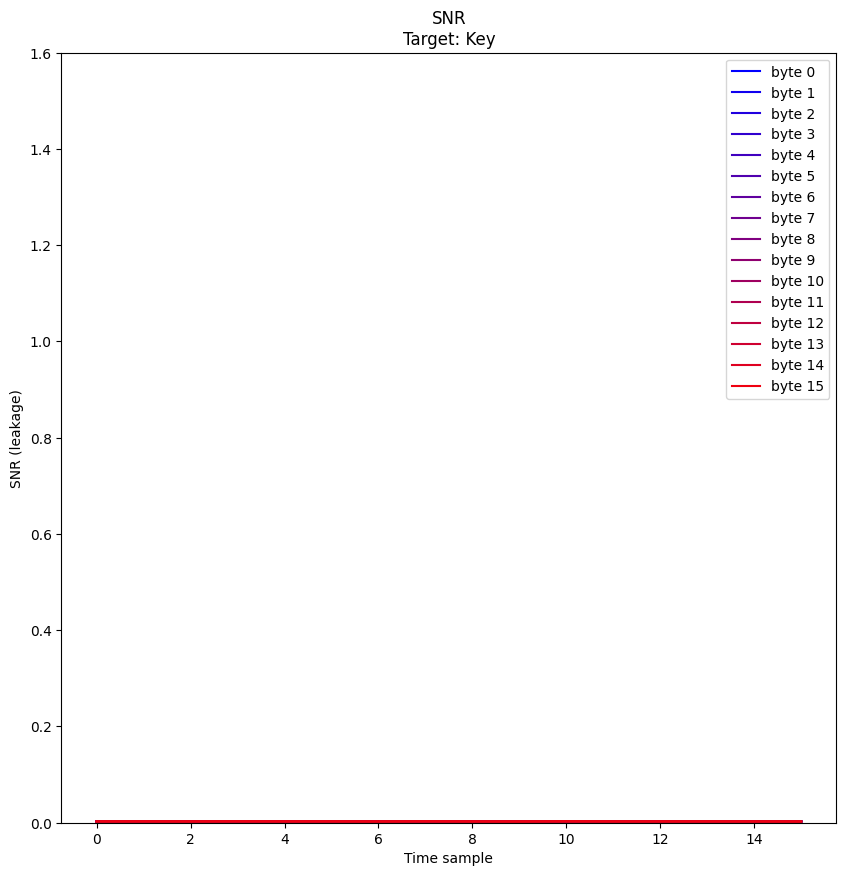

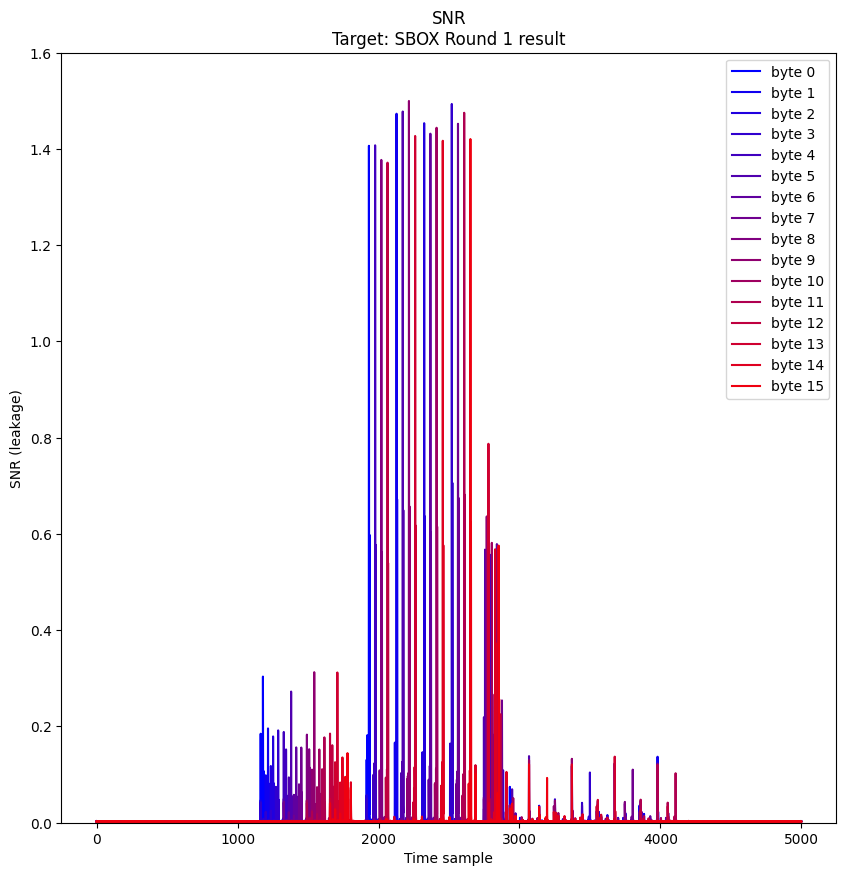

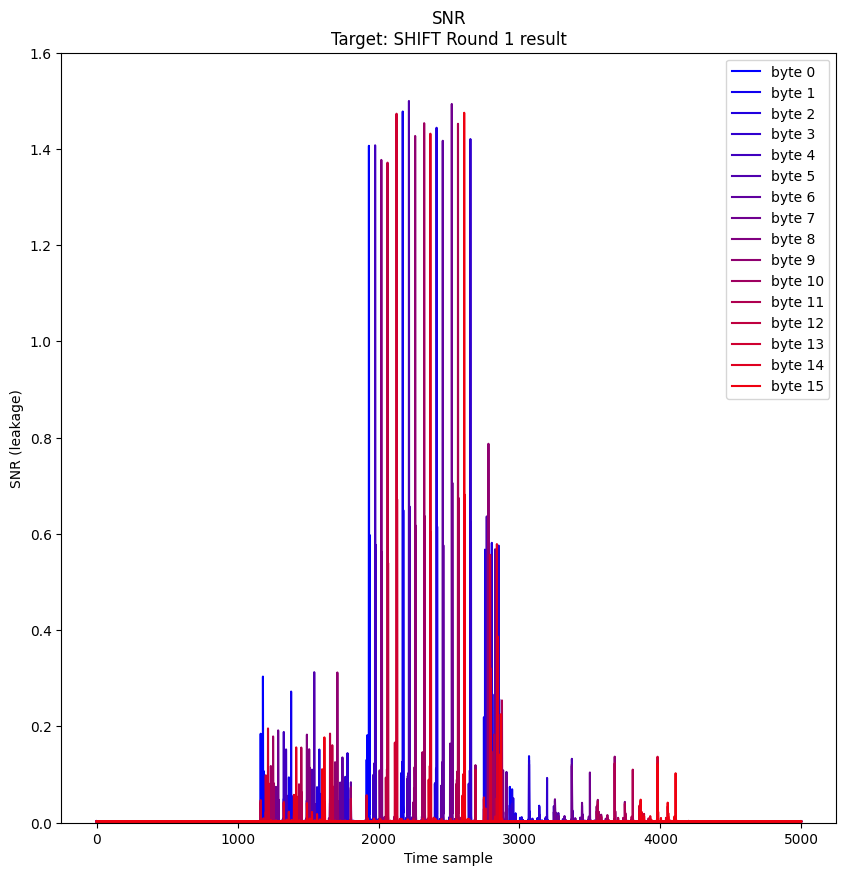

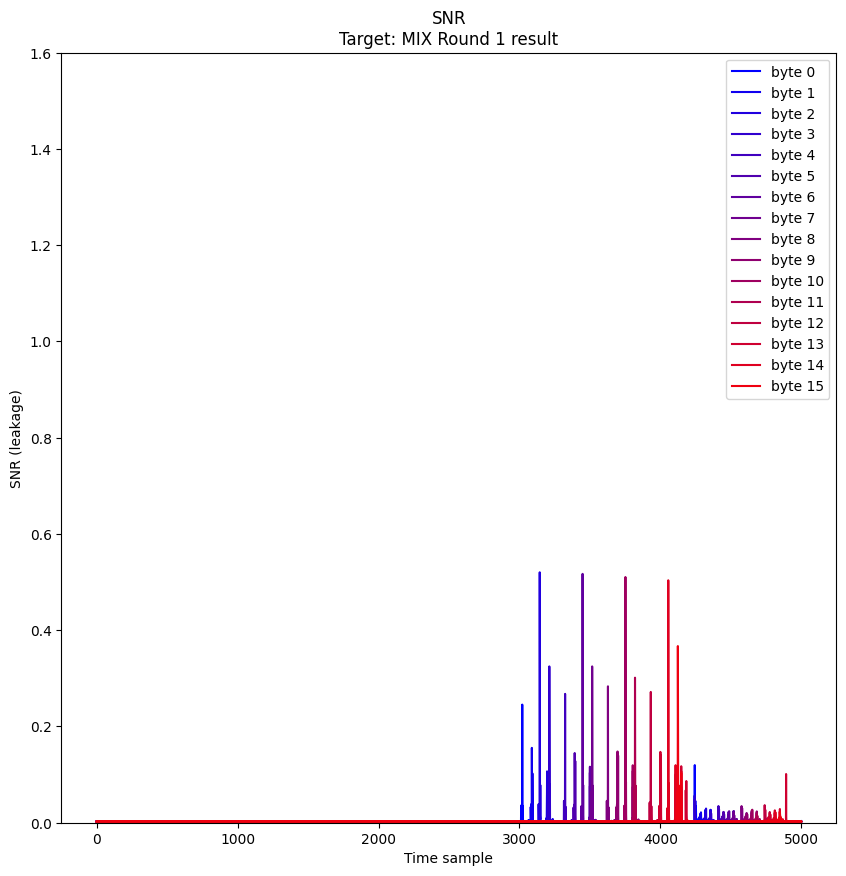

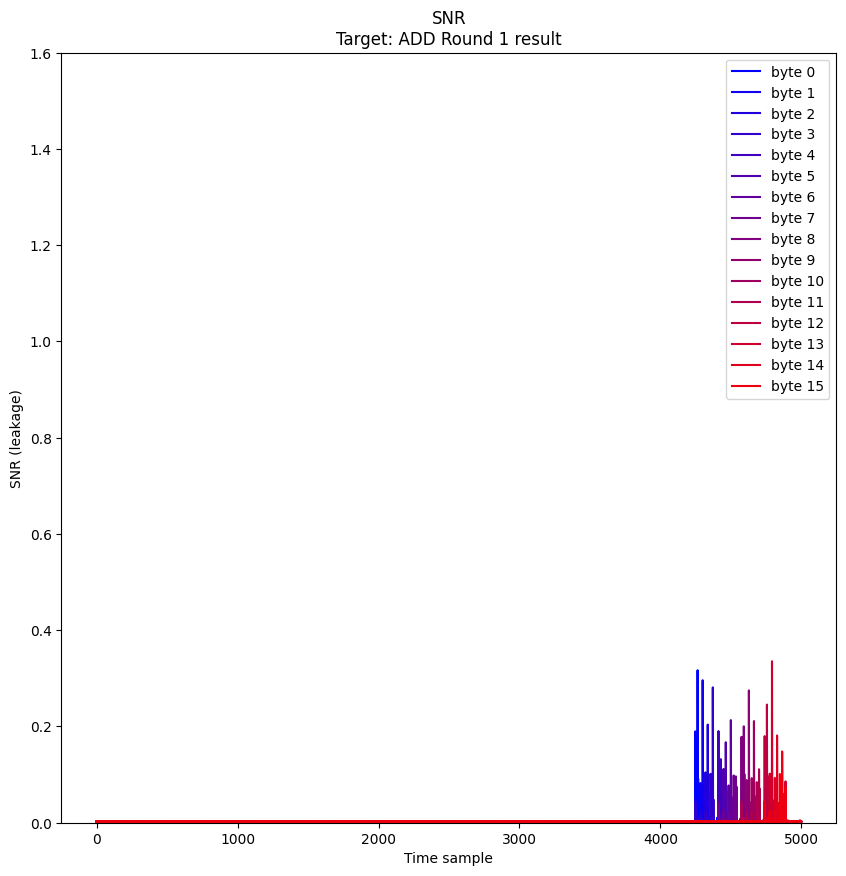

In [ ]:
# from scalib.metrics import SNR
from matplotlib import pyplot as plt
from time import perf_counter_ns
import os
import numpy as np

from src.zarr_handler import ZarrHandler
from src.dask_operation import OracleAES, SNR, NICV

def preset_plot(data: np.ndarray, plot_size: tuple[int, int], lq_name: str, subtitle: str, yscale: tuple[float|int, float|int]):
    plt.figure(figsize=plot_size)
    for i in range(data.shape[0]):
        plt.plot(np.arange(data.shape[1]), data[i, :], label=f"byte {i}", color=(i/data.shape[0], 0, 1-(i/data.shape[0])))
        ax = plt.gca()
        ax.set_ylim(bottom=yscale[0], top=yscale[1])
        plt.legend(loc='upper right')
        plt.title(f"{lq_name}\n{subtitle}")
        plt.xlabel("Time sample")
        plt.ylabel(f"{lq_name} (leakage)")
    plt.savefig(f"figure-{subtitle.lower()}.png", dpi=300)
    # plt.show()

# import dataset
def local_dataset(name: str) -> str:
    return os.path.join(os.path.expanduser("~"), "Nextcloud", "UNH", "Research", "Projects", "SCA Datasets", name + '.zarr')
dataset_name = "SAM4S 100000 random Traces [50c]"
dset = ZarrHandler(local_dataset(dataset_name), chunks=10000)

# get data
k = dset.get("key")
ct = dset.get("ciphertext")
t = dset.get("traces")

snr = SNR(t, ct.compute())
preset_plot(snr.snr, (10, 10), "SNR", f"Target: Ciphertext (input)", (0, 1.6))

# instantiate oracle
for target in ((1, 'sbox'), (1, 'shift'), (1, 'mix'), (1, 'add')):
    oracle = OracleAES(
        aes_type=128, keys=k, texts=ct, 
        round=target[0], step=target[1],    # finds intermediate state at round 'round' step 'step'
        lazy=False                          # lazy=False computes results immedietly on init
    )

    # instantiate SNR
    snr = SNR(t, oracle.result)

    # plot results
    preset_plot(snr.snr, (10, 10), "SNR", f"Target: {target[1].upper()} Round {target[0]} result", (0, 1.6))




## Figures / data for OPTIMIST Presentation

Module AES128 not found, compiling instrumented Tiny-AES shared library


AES128.c:988:13: warning: ‘Cipher’ defined but not used [-Wunused-function]
  988 | static void Cipher(state_t* state, const uint8_t* RoundKey)
      |             ^~~~~~


Module AES192 not found, compiling instrumented Tiny-AES shared library


AES192.c:624:9: warning: ‘AES_KEYLEN’ redefined
  624 | #define AES_KEYLEN 16   // Key length in bytes
      |         ^~~~~~~~~~
<command-line>: note: this is the location of the previous definition
AES192.c:988:13: warning: ‘Cipher’ defined but not used [-Wunused-function]
  988 | static void Cipher(state_t* state, const uint8_t* RoundKey)
      |             ^~~~~~


Module AES256 not found, compiling instrumented Tiny-AES shared library


AES256.c:624:9: warning: ‘AES_KEYLEN’ redefined
  624 | #define AES_KEYLEN 16   // Key length in bytes
      |         ^~~~~~~~~~
<command-line>: note: this is the location of the previous definition
AES256.c:988:13: warning: ‘Cipher’ defined but not used [-Wunused-function]
  988 | static void Cipher(state_t* state, const uint8_t* RoundKey)
      |             ^~~~~~


Ignoring exception:
('No input specification for OracleAES: input_conditions must be declared in OracleAES.__new__', "'OracleAES' object has no attribute 'input_conditions'")
Ignoring exception:
('No input specification for OracleAES: input_conditions must be declared in OracleAES.__new__', "'OracleAES' object has no attribute 'input_conditions'")
Ignoring exception:
('No input specification for OracleAES: input_conditions must be declared in OracleAES.__new__', "'OracleAES' object has no attribute 'input_conditions'")
Ignoring exception:
('No input specification for OracleAES: input_conditions must be declared in OracleAES.__new__', "'OracleAES' object has no attribute 'input_conditions'")


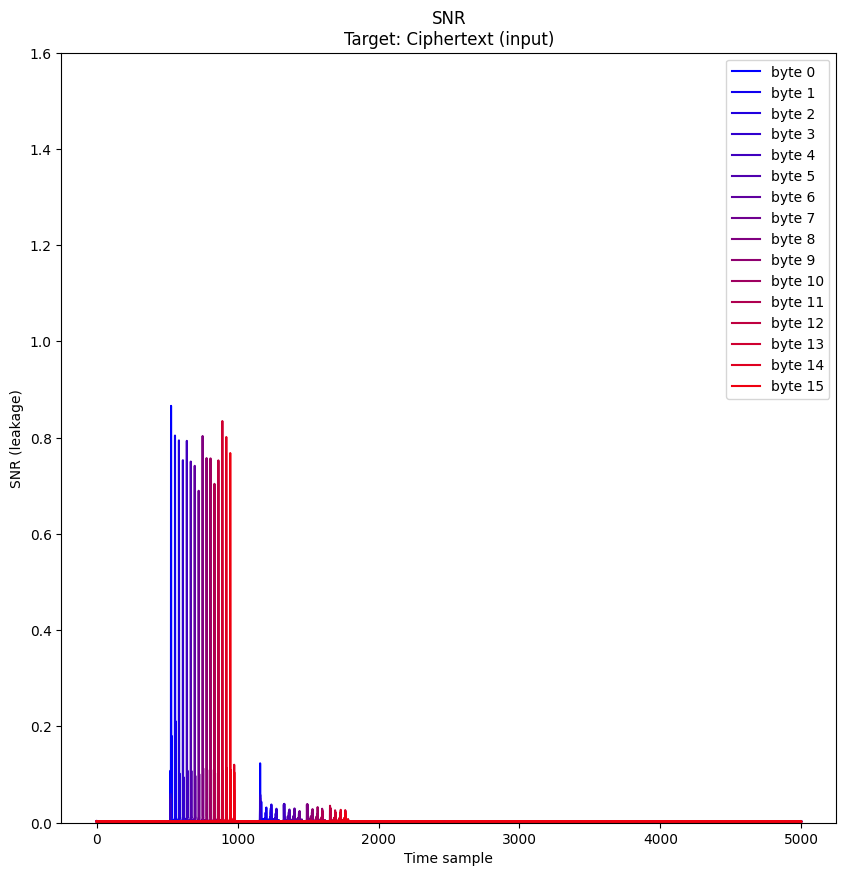

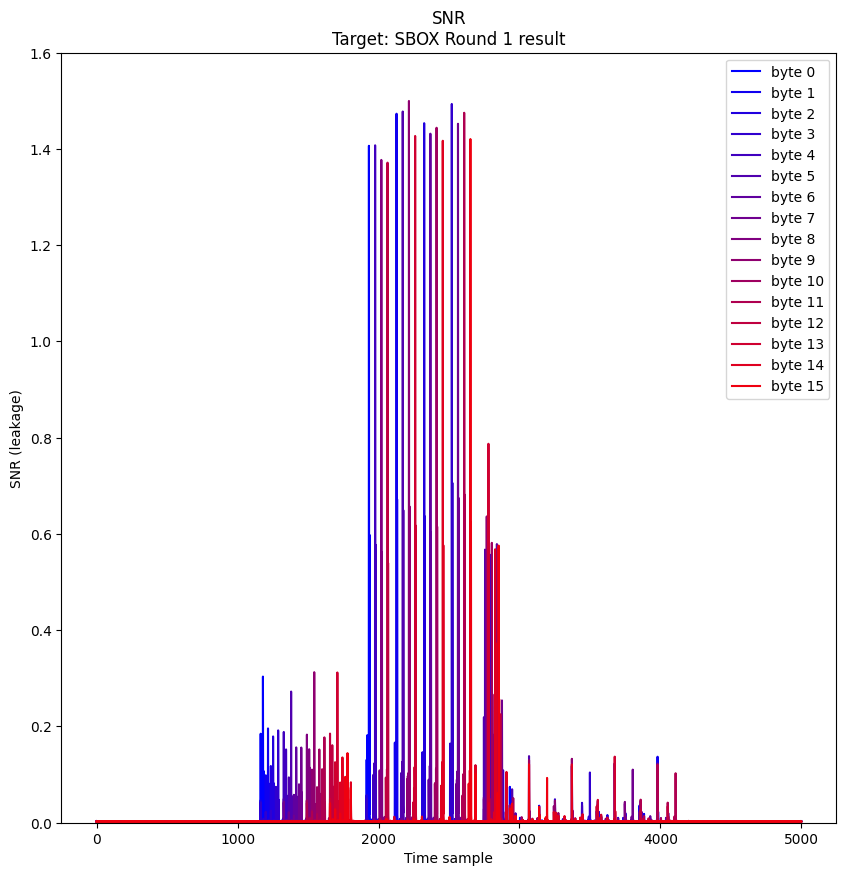

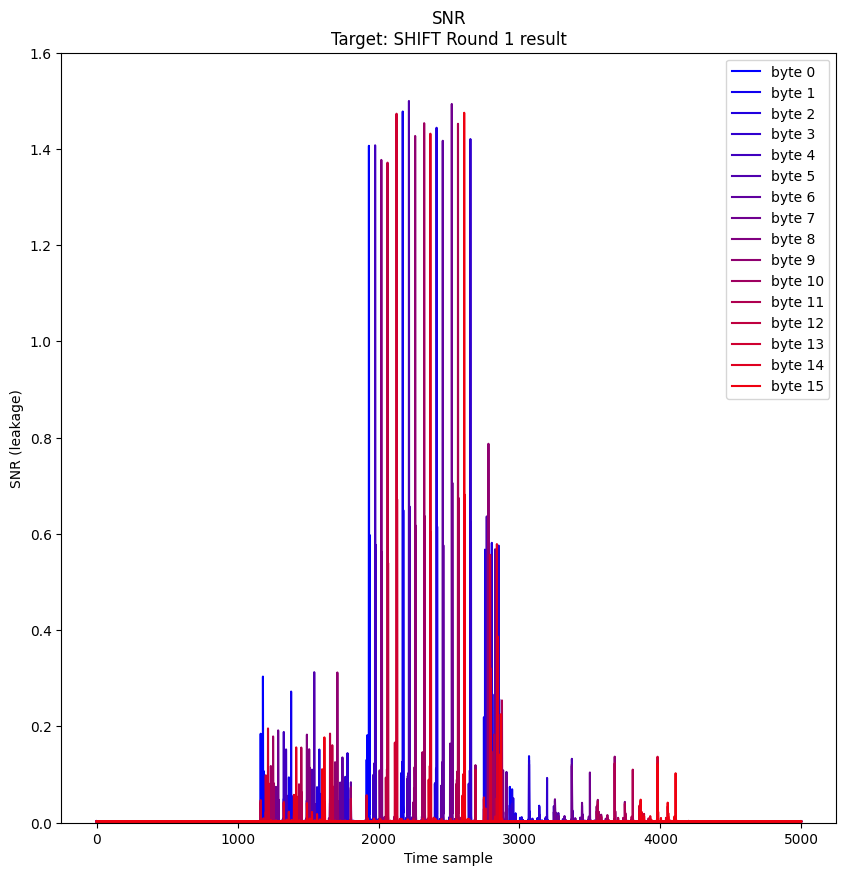

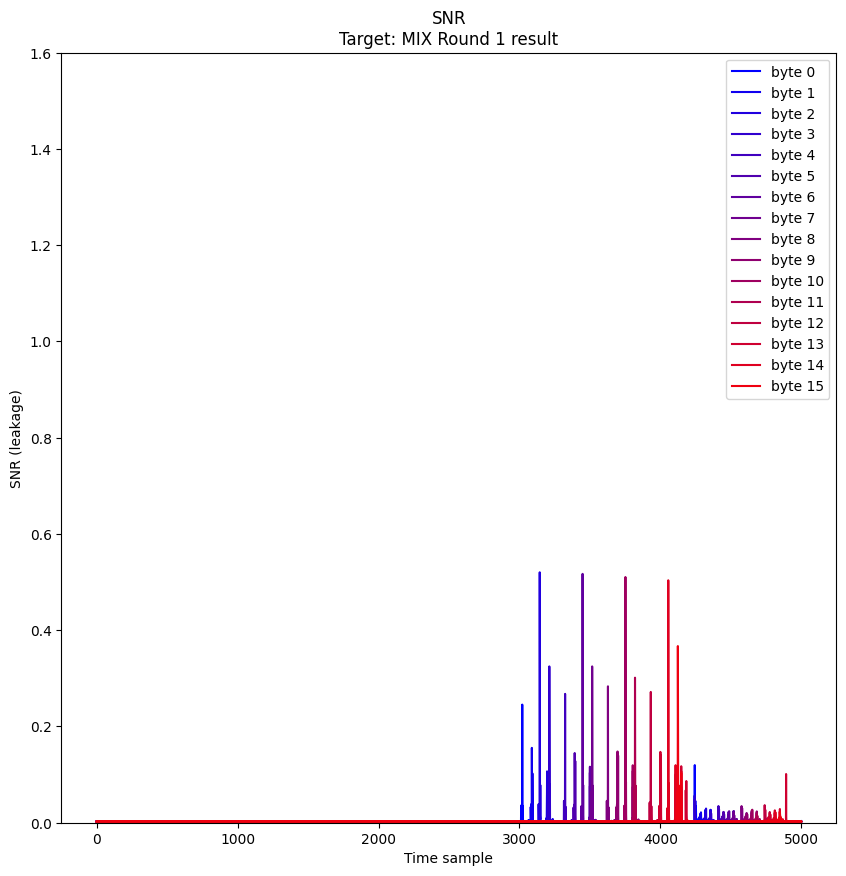

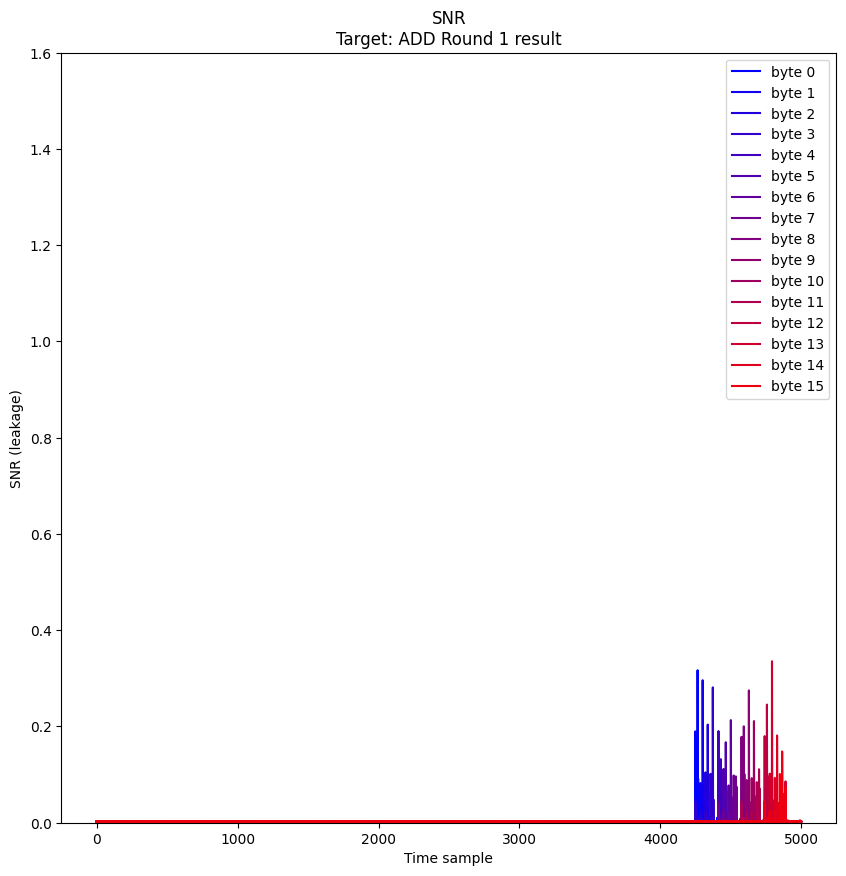

In [1]:
from matplotlib import pyplot as plt
from time import perf_counter_ns
import os
import numpy as np

from src.zarr_handler import ZarrHandler
from src.dask_operation import OracleAES, SNR, NICV

def preset_plot(data: np.ndarray, plot_size: tuple[int, int], lq_name: str, subtitle: str, yscale: tuple[float|int, float|int]):
    plt.figure(figsize=plot_size)
    for i in range(data.shape[0]):
        plt.plot(np.arange(data.shape[1]), data[i, :], label=f"byte {i}", color=(i/data.shape[0], 0, 1-(i/data.shape[0])))
        ax = plt.gca()
        ax.set_ylim(bottom=yscale[0], top=yscale[1])
        plt.legend(loc='upper right')
        plt.title(f"{lq_name}\n{subtitle}")
        plt.xlabel("Time sample")
        plt.ylabel(f"{lq_name} (leakage)")
    plt.savefig(f"figure-{subtitle.lower()}.png", dpi=300)
    # plt.show()

# import dataset
def local_dataset(name: str) -> str:
    return os.path.join(os.path.expanduser("~"), "Nextcloud", "UNH", "Research", "Projects", "SCA Datasets", name + '.zarr')
dataset_name = "SAM4S 100000 random Traces [50c]"
dset = ZarrHandler(local_dataset(dataset_name), chunks=10000)

# get data
k = dset.get("key")
ct = dset.get("ciphertext")
t = dset.get("traces")

snr = SNR(t, ct.compute())
preset_plot(snr.snr, (10, 10), "SNR", f"Target: Ciphertext (input)", (0, 1.6))

for target in ((1, 'sbox'), (1, 'shift'), (1, 'mix'), (1, 'add')):
    # instantiate oracle
    oracle = OracleAES(
        aes_type=128, keys=k, texts=ct, 
        round=target[0], step=target[1],    # finds intermediate state at round 'round' step 'step'
        lazy=False                          # lazy=False computes results immedietly on init
    )

    # instantiate SNR
    snr = SNR(t, oracle.result)

    # plot results
    preset_plot(snr.snr, (10, 10), "SNR", f"Target: {target[1].upper()} Round {target[0]} result", (0, 1.6))



Ignoring exception:
('No input specification for OracleAES: input_conditions must be declared in OracleAES.__new__', "'OracleAES' object has no attribute 'input_conditions'")
Ignoring exception:
('No input specification for OracleAES: input_conditions must be declared in OracleAES.__new__', "'OracleAES' object has no attribute 'input_conditions'")


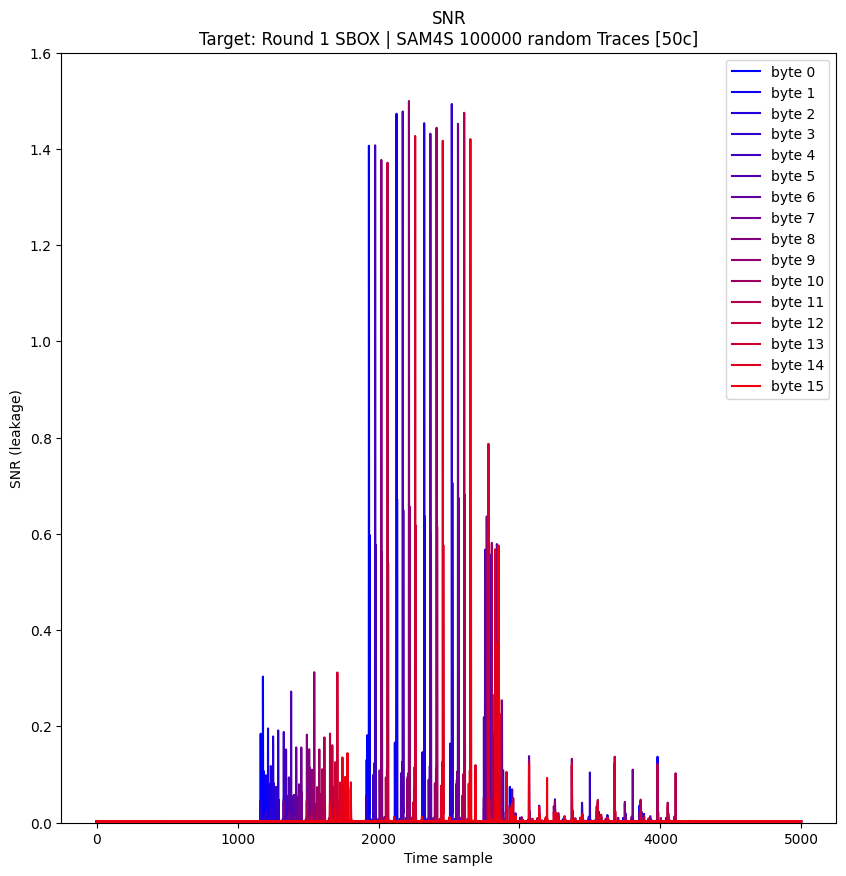

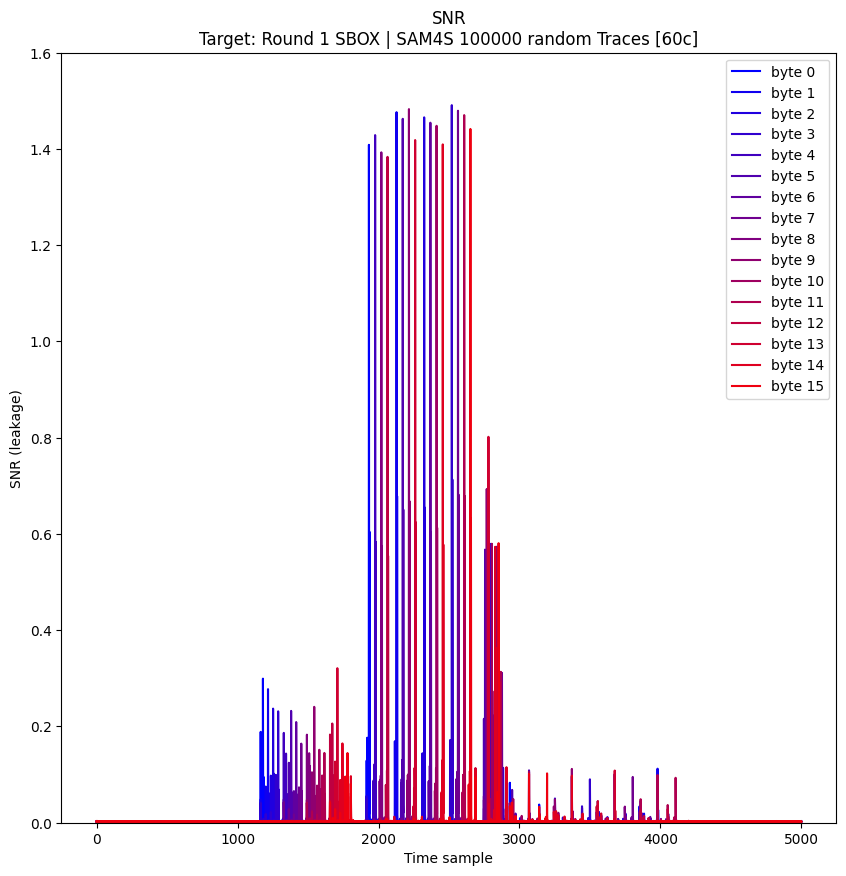

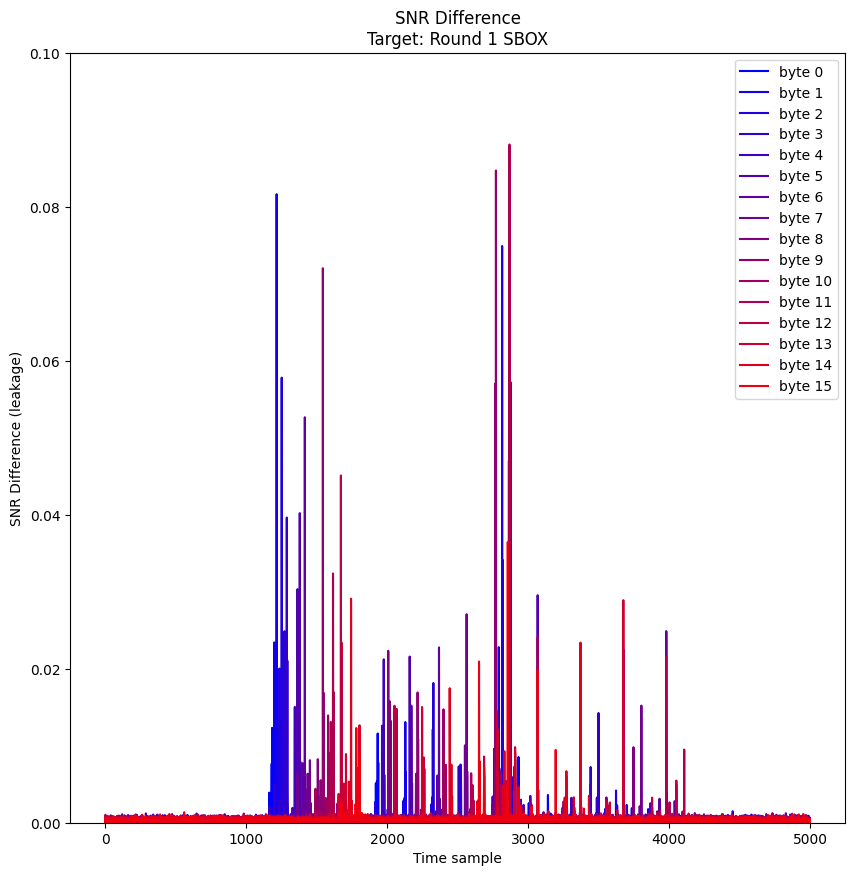

In [12]:
dataset_names = [
    "SAM4S 100000 random Traces [50c]",
    "SAM4S 100000 random Traces [60c]"
]

datasets = [ ZarrHandler(local_dataset(name), chunks=10000) for name in dataset_names ]    
oracles = [ OracleAES(aes_type=128, keys=dset.get("key"), texts=dset.get("ciphertext"), round=1, step='sbox', lazy=False) for dset in datasets ]
results = [ SNR(dset.get("traces"), oracle.result).snr for dset, oracle in zip(datasets, oracles) ]

for (result, name) in zip(results, dataset_names):
    preset_plot(result, (10, 10), "SNR", f"Target: Round 1 SBOX | {name}", (0, 1.6))

preset_plot(np.abs(np.subtract(results[0], results[1])), (10, 10), "SNR Difference", f"Target: Round 1 SBOX", (0, 0.1))
